# Problem 2 - ISOMAP

In [170]:
import numpy as np 
from scipy.spatial.distance import cdist
import scipy.io
import matplotlib.pyplot as plt 
import networkx as nx
import pandas as pd
import timeit
import scipy.sparse

## $\epsilon$-ISOMAP

In [171]:
def isomap(image_data, method = "epsilon", distance = "euclidean", components = 2, threshold = 0.143):
    # calculate distance matrix
    dist = cdist(image_data, image_data, metric = distance)

    if method == "k":
        neighbors = np.copy(dist)
        neighbors.partition(100, -1)
        # adjacency matrix and neighborhood graph
        adj = dist * (np.less_equal(dist, neighbors[:,100].reshape((-1,1))))
        adj = np.minimum(adj, adj.T)
    else:
        # determine epsilon
        threshold = np.amax(np.quantile(dist, axis = 1, q = threshold))
        # adjacency matrix and neighborhood graph
        adj = dist * (dist <= threshold)

    adj_matrix = np.matrix(adj, dtype = [("weight", float)])
    graph = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph())

    # create shortest path graph
    shortest_path = nx.all_pairs_dijkstra_path_length(graph, weight = "weight")
    path_dists = [(p[0], k, v) for p in shortest_path for k, v in p[1].items()]
    path_df = pd.DataFrame.from_dict(path_dists)
    path_df.columns = ['from', 'to', 'dist']
    path_df = path_df.sort_values(by = ['from','to'])
    path_matrix = pd.pivot_table(path_df, index = "from", columns = "to", values = "dist")
    neighbors = np.array(path_matrix)

    # centering matrix
    centering = np.diag(np.ones(len(neighbors))) - 1. / len(neighbors)
    centered_dist = -0.5 * centering.dot(np.square(neighbors)).dot(centering)

    # eigenvalues of centered distance matrix
    k = components
    eigenvalues, eigenvectors = np.linalg.eigh(centered_dist)
    lam, w = eigenvalues[-k:][::-1], eigenvectors[:, -k:][:,::-1]
    lam = lam.reshape((-1, k))
    embeds = w * (lam**0.5)

    return adj, neighbors, embeds

## PCA

In [172]:
def pca(image_data, components = 2): # n_features, n_samples
    # mean and covariance matrix
    mu = np.mean(image_data, axis = 1).reshape(-1,1)
    xc = image_data - mu
    cov = xc.dot(xc.T) / len(image_data.T)

    # largest eigenvalues and corresponding eigenvectors
    k = components
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    lam, w = eigenvalues[-k:][::-1], eigenvectors[:, -k:][:,::-1]
    lam = lam.reshape((k, -1))
    pcs = w.T.dot(xc) / np.sqrt(lam)

    return pcs

## Load data

In [173]:
# read image data
image_data = scipy.io.loadmat('../Inputs/isomap.mat')['images'].T

# for plotting purpose
n, v = image_data.shape
h, w = int(np.sqrt(v)), int(np.sqrt(v))
images = image_data.reshape((n, h, w))

## Run $\epsilon$-ISOMAP

In [174]:
# Euclidean distance
adj, _, embeds_epsilon = isomap(image_data)
_, _, embeds_epsilon_10 = isomap(image_data, threshold=0.0143)

In [175]:
# Manhattan distance
_, _, embeds_epsilon_manhattan = isomap(image_data, distance = "cityblock")

## Run k-ISOMAP

In [176]:
_, _, embeds_k = isomap(image_data, method = "k")

## Run PCA

In [177]:
pcs = pca(image_data.T)

## Plottings

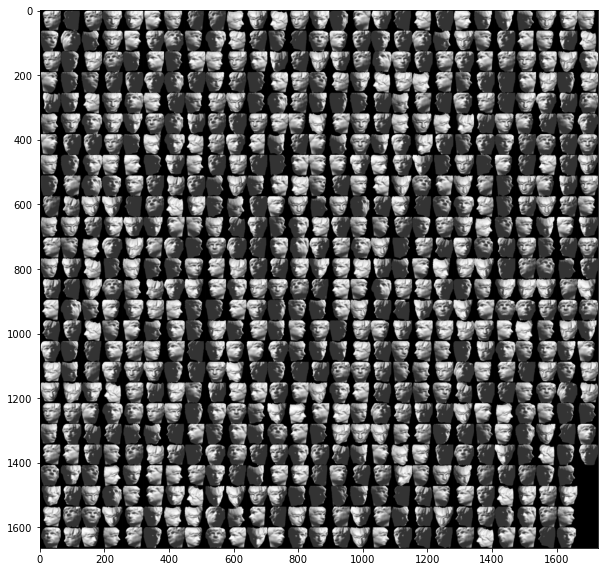

In [178]:
# plot image
cols = int(np.sqrt(n))
rows = n // cols + 1
image = np.zeros((rows*h, cols*w))
count = 0

for r in range(rows):
    for c in range(cols):
        if count == n:
            break
        image[r*h : (r+1)*h, c*w : (c+1)*w] = images[count,:,:]
        count += 1

plt.figure(figsize = (10, 10))
plt.imshow(image.T, cmap='gray')
plt.show()

## Adjacency Matrix (Euclidean Distance)

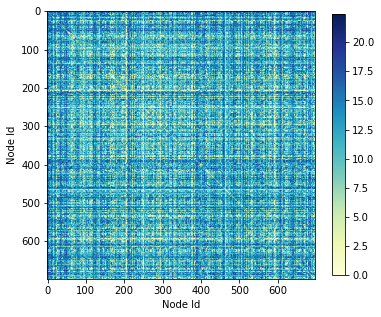

In [179]:
# plot adjacency matrix for epsilon-ISOMAP
plt.figure(figsize = (6,6))
plt.imshow(adj, cmap = "YlGnBu")
plt.xlabel("Node Id")
plt.ylabel("Node Id")
plt.colorbar(shrink = 0.8)
plt.savefig("../Outputs/prob2_adjacency_mat.png")
plt.show()

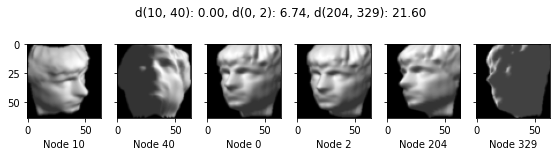

In [180]:
# plot random pair of nodes
fig, axs = plt.subplots(nrows = 1, ncols = 6, sharex=True, sharey=True, figsize = (8,2))
fig.suptitle("d(%d, %d): %.2f, d(%d, %d): %.2f, d(%d, %d): %.2f" % (10, 40, adj[10,40], 0, 2, adj[0, 2], 204, 329, adj[204, 329]))

fig.tight_layout(w_pad=0.0)
axs[0].imshow(images[10,:,:].T, cmap = "gray")
axs[0].set_xlabel("Node 10")
axs[1].imshow(images[40,:,:].T, cmap = "gray")
axs[1].set_xlabel("Node 40")

axs[2].imshow(images[0,:,:].T, cmap = "gray")
axs[2].set_xlabel("Node 0")
axs[3].imshow(images[2,:,:].T, cmap = "gray")
axs[3].set_xlabel("Node 2")

axs[4].imshow(images[204,:,:].T, cmap = "gray")
axs[4].set_xlabel("Node 204")
axs[5].imshow(images[329,:,:].T, cmap = "gray")
axs[5].set_xlabel("Node 329")

plt.show()

## Embeddings (Euclidean Distance)

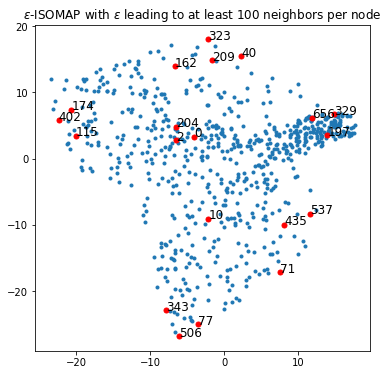

In [181]:
# plot embeddings from epsilon-ISOMAP
plt.figure(figsize = (6, 6))
plt.plot(embeds_epsilon[:,0], embeds_epsilon[:,1], 'o', markersize = 3)
plt.title("$\epsilon$-ISOMAP with $\epsilon$ leading to at least 100 neighbors per node")

test = [0, 2, 10, 40, 204, 329, 656, 197]
left = [115, 402, 174]
bottom = [506, 77, 343]
right = [435, 71, 537]
top = [323, 162, 209]

for t in test + left + bottom + right + top:
    plt.plot(embeds_epsilon[t,0], embeds_epsilon[t,1], 'ro', markersize = 5)
    plt.annotate(str(t), (embeds_epsilon[t,0], embeds_epsilon[t,1]), fontsize = 12)

plt.savefig("../Outputs/prob2_embedding_100.png")
plt.show()

## Embeddings (Manhattan Distance)

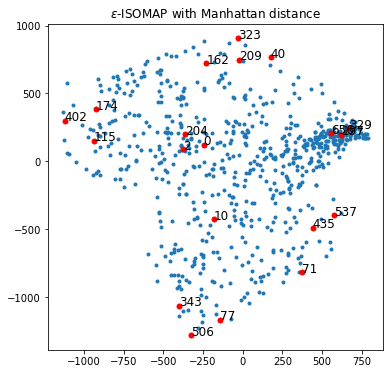

In [182]:
# plot embeddings from epsilon-ISOMAP
plt.figure(figsize = (6, 6))
plt.plot(embeds_epsilon_manhattan[:,0], embeds_epsilon_manhattan[:,1], 'o', markersize = 3)
plt.title("$\epsilon$-ISOMAP with Manhattan distance")

for t in test + left + bottom + right + top:
    plt.plot(embeds_epsilon_manhattan[t,0], embeds_epsilon_manhattan[t,1], 'ro', markersize = 5)
    plt.annotate(str(t), (embeds_epsilon_manhattan[t,0], embeds_epsilon_manhattan[t,1]), fontsize = 12)

plt.savefig("../Outputs/prob2_embedding_manhattan.png")
plt.show()

## Embedding (Euclidean with 10+ neighbors per node)

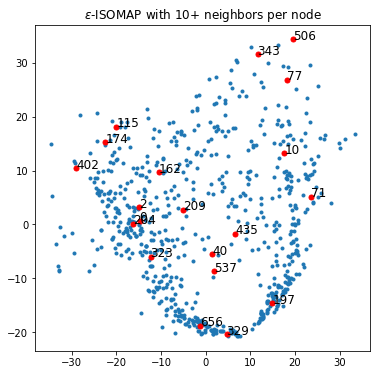

In [183]:
# plot embeddings from epsilon-ISOMAP
plt.figure(figsize = (6, 6))
plt.plot(embeds_epsilon_10[:,0], embeds_epsilon_10[:,1], 'o', markersize = 3)
plt.title("$\epsilon$-ISOMAP with 10+ neighbors per node")

for t in test + left + bottom + right + top:
    plt.plot(embeds_epsilon_10[t,0], embeds_epsilon_10[t,1], 'ro', markersize = 5)
    plt.annotate(str(t), (embeds_epsilon_10[t,0], embeds_epsilon_10[t,1]), fontsize = 12)

plt.savefig("../Outputs/prob2_embedding_10.png")
plt.show()

## Embedding (k-ISOMAP)

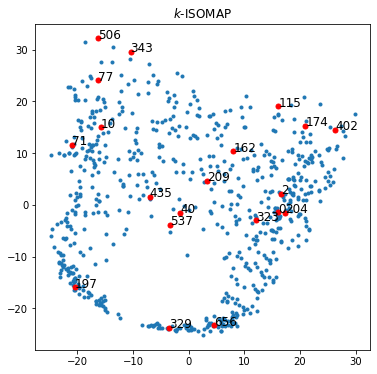

In [184]:
# plot embeddings from epsilon-ISOMAP
plt.figure(figsize = (6, 6))
plt.plot(embeds_k[:,0], embeds_k[:,1], 'o', markersize = 3)
plt.title("$k$-ISOMAP")

for t in test + left + bottom + right + top:
    plt.plot(embeds_k[t,0], embeds_k[t,1], 'ro', markersize = 5)
    plt.annotate(str(t), (embeds_k[t,0], embeds_k[t,1]), fontsize = 12)

plt.show()

## Principal Components

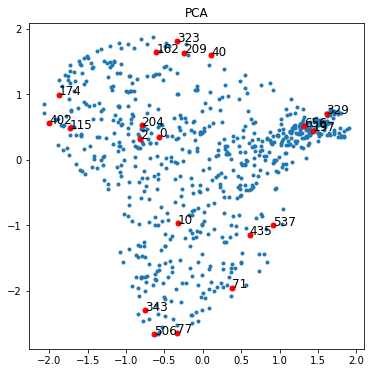

In [185]:
# plot principal components
plt.figure(figsize = (6, 6))
plt.plot(pcs[0,:], pcs[1,:], 'o', markersize = 3)
plt.title("PCA")

test = [0, 2, 10, 40, 204, 329, 656, 197]
left = [115, 402, 174]
bottom = [506, 77, 343]
right = [435, 71, 537]
top = [323, 162, 209]

for t in test + left + bottom + right + top:
    plt.plot(pcs[0,t], pcs[1,t], 'ro', markersize = 5)
    plt.annotate(str(t), (pcs[0,t], pcs[1,t]), fontsize = 12)

plt.savefig("../Outputs/prob2_pca.png")
plt.show()

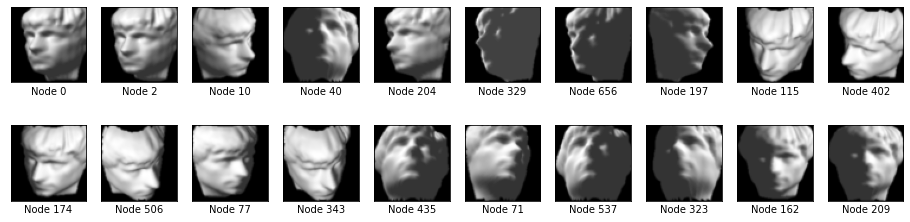

In [186]:
# ISOMAP image test
images_test = test + left + bottom + right + top
t = 0
plt.figure(figsize = (16,4))
for i in range(2) :
    for j in range(10):
        plt.subplot2grid((2, 10), (i, j))
        plt.imshow(images[images_test[t]].T, cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Node %d" % images_test[t])
        t+=1